* Импортируем необходимые библиотеки

In [3]:
from skimage.io import imread, imsave, imshow
from skimage import img_as_float, img_as_ubyte
from numpy.fft import fft2, fftshift
import matplotlib.pyplot as plt
import numpy as np
import math

%matplotlib inline

### 1. Подготовьте одно изображение для экспериментов с гауссовской и лапласовской пирамидой.

* Выбираем амурского тигра

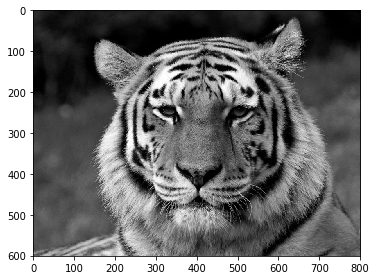

In [4]:
img = img_as_float(imread("tiger-color.png", 1))
imshow(img)

### 2. Постройте гауссовскую пирамиду изображения из не менее чем пяти слоев.

* значения функции Гаусса

In [5]:
def gauss(x, y, sigma):
    return math.exp(-(x**2 + y**2) / (2 * sigma**2)) / (2 * math.pi * sigma**2)

* построение гауссовского фильтра

In [6]:
def gauss_filter_func(sigma):
    k = round(3 * sigma)
    size = 2 * k + 1
    
    gauss_filter = [[gauss(i - k, j - k, sigma) for i in range(size)] for j in range(size)]
    gauss_filter = gauss_filter / np.sum(gauss_filter)
    return gauss_filter

* функция построения гауссовской пирамиды
* как известно, при свертке размер изображения уменьшается - будем добавлять изображениям рамку из нулей

In [7]:
def gaussian_pyramid(img, sigma, n_layers):
    output = [img]
    out_img = np.copy(img)
    
    gauss_filter = gauss_filter_func(sigma)
    k = round(3 * sigma)
    size = 2 * k + 1
    
    for i in range(n_layers):
        H, W = img.shape
        temp_img = np.zeros((H + 2 * k, W + 2 * k))
        temp_img[k: -k, k: -k] = out_img[:,:]
    
        H, W = temp_img.shape
        out_img = [[np.sum(gauss_filter * temp_img[i:i+size, j:j+size])
                    for j in range(W - size + 1)]
                   for i in range(H - size + 1)]      
        out_img = np.clip(out_img, 0, 1)
        output.append(out_img)
    return output

* функция для визуализации полученных результатов

In [8]:
def plot_pyramid(pyramid, start=0):
    nrows, ncols = len(pyramid), 2

    fig = plt.figure(figsize=(10,26))
    axes = fig.subplots(nrows=nrows, ncols=ncols)

    for i in range(nrows):
        plt.subplot(nrows, ncols, 2 * i + 1).set_title(u'Слой № ' + str(start + i))
        plt.imshow(pyramid[i], cmap='gray')

        plt.subplot(nrows, ncols, 2 * i + 2).set_title(u'Слой № ' + str(start + i))
        freq = np.log(1 + abs(fftshift(fft2(pyramid[i]))))
        plt.imshow(freq, cmap='gray')
    plt.show()

* рассмотрим работу гауссовского фильтра при $\sigma = 3$

sigma = 3


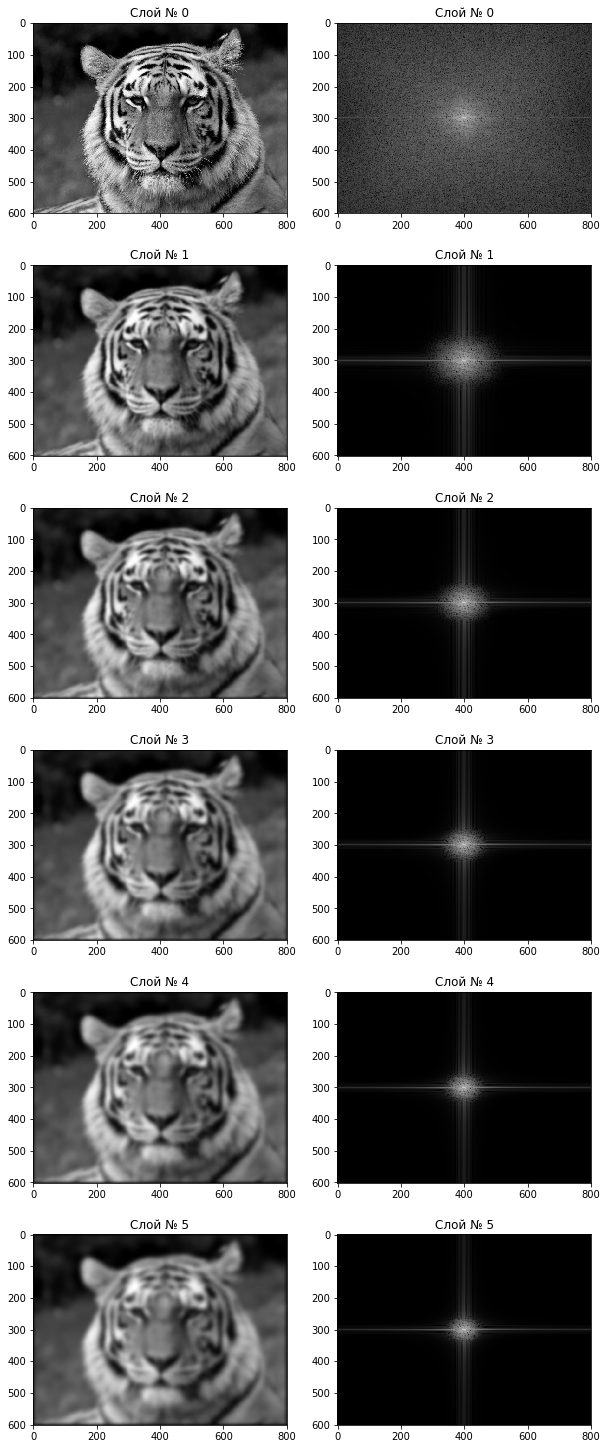

In [10]:
pyramid = gaussian_pyramid(img, 3, 5)
print("sigma = 3")
plot_pyramid(pyramid)

* рассмотрим работу гауссовского фильтра при $\sigma = 5$

sigma = 5


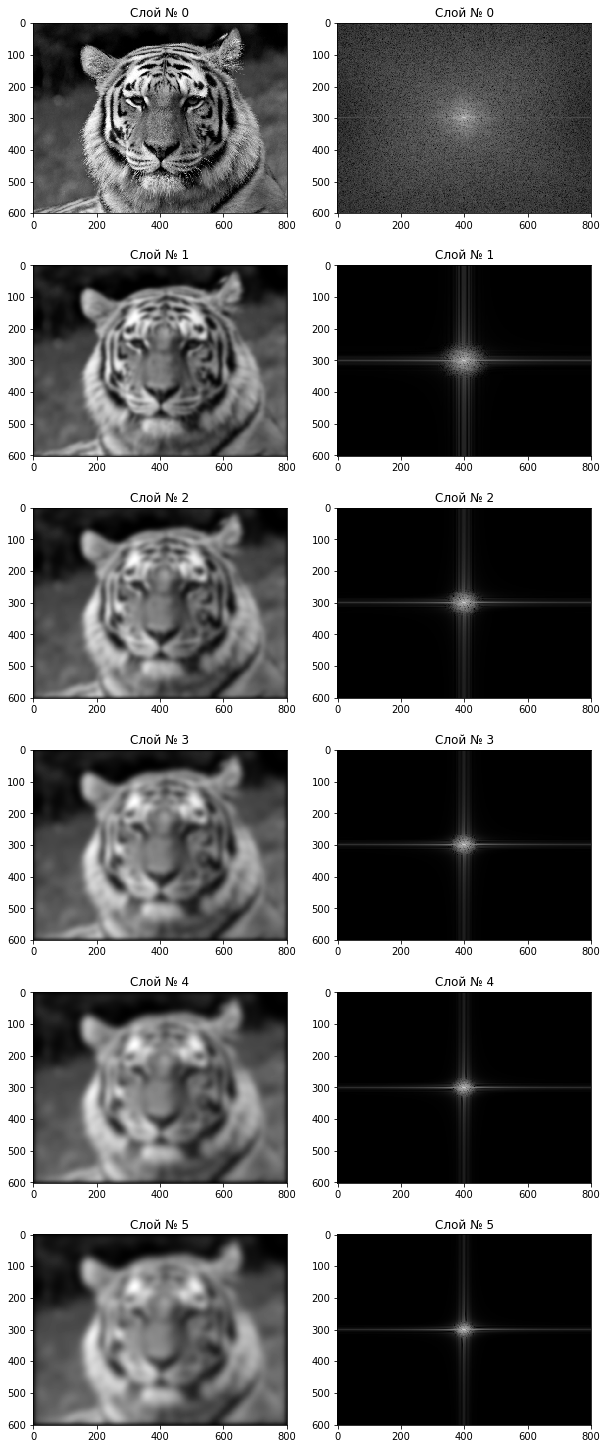

In [11]:
pyramid = gaussian_pyramid(img, 5, 5)
print("sigma = 5")
plot_pyramid(pyramid)

* рассмотрим работу гауссовского фильтра при $\sigma = 8$

sigma = 8


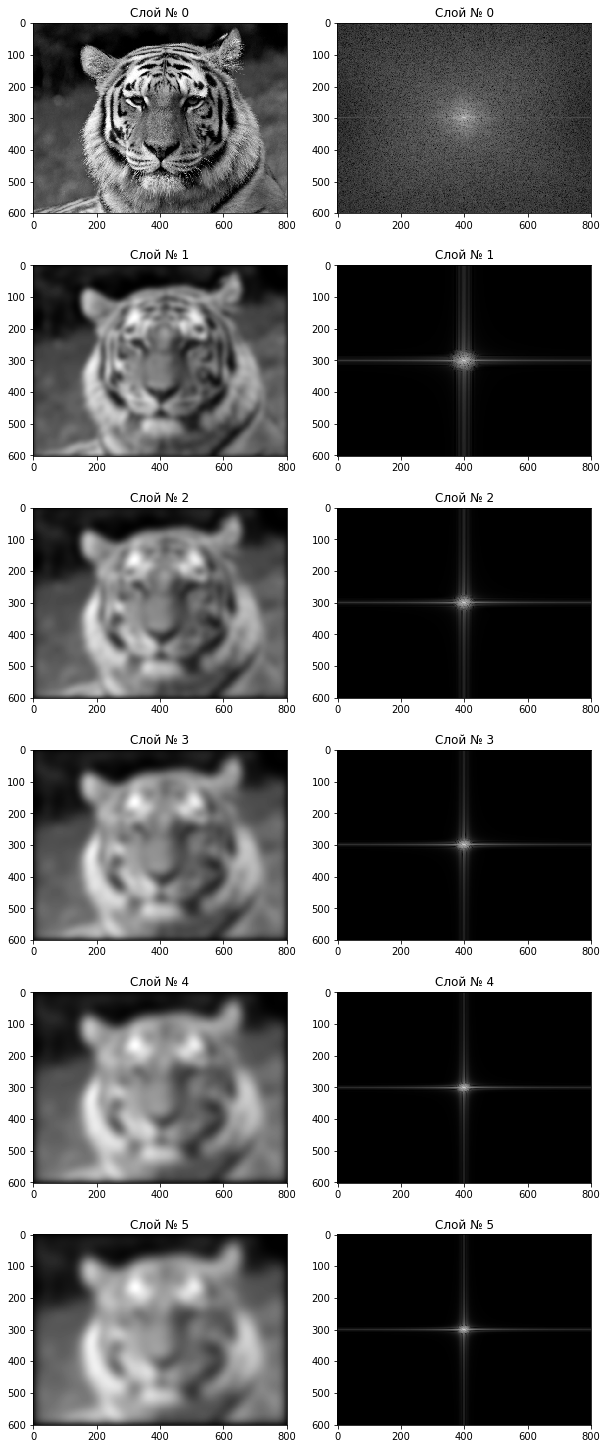

In [12]:
pyramid = gaussian_pyramid(img, 8, 5)
print("sigma = 8")
plot_pyramid(pyramid)

* Заметим, что применение гауссовского фильтра уменьшает диапазон частот изображений

### 3. Проведите аналогичные эксперименты с лапласовской пирамидой.

* функция построения лапласовской пирамиды, использующая гауссовскую пирамиду

In [17]:
def laplace_pyramid(img, sigma, n_layers):
    g_pyramid = gaussian_pyramid(img, sigma, n_layers)
    output = []
    
    for i in range(len(g_pyramid) - 2):
        out_img = g_pyramid[i] - g_pyramid[i + 1]
        out_img = np.clip(out_img, 0, 1)
        output.append(out_img)
    output.append(g_pyramid[-1])
    return output

* рассмотрим лапласовскую пирамиду при $\sigma = 3$

sigma = 3


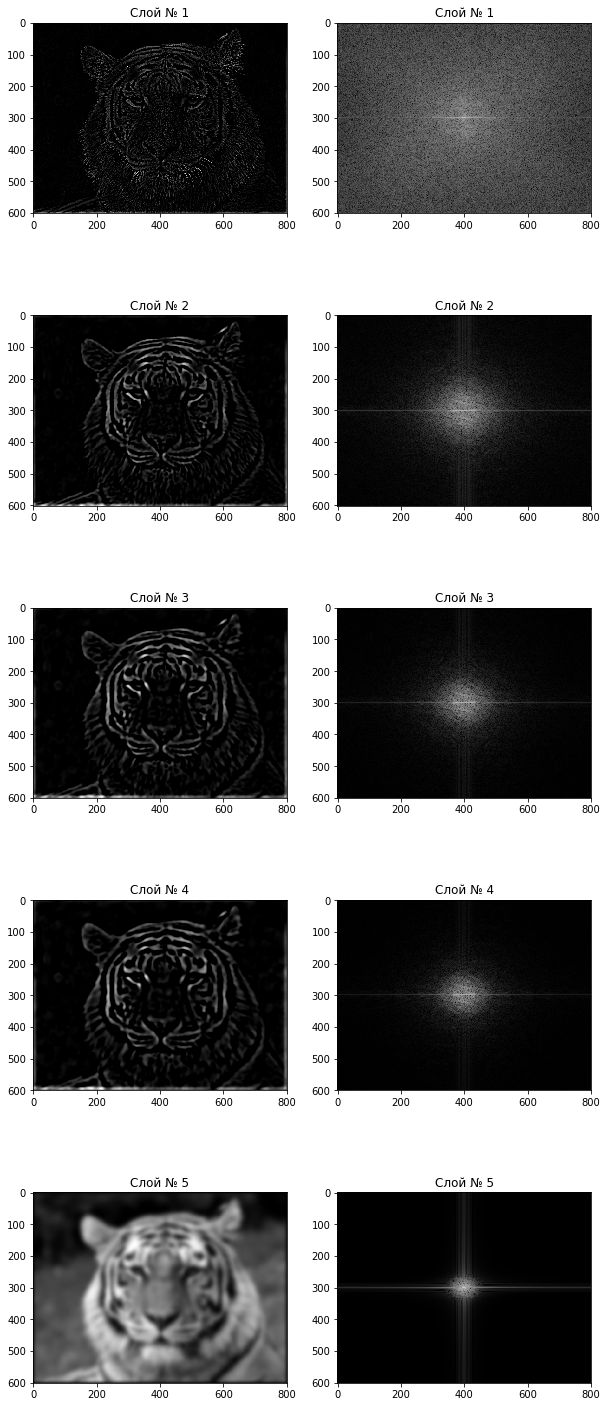

In [18]:
pyramid = laplace_pyramid(img, 3, 5)
print("sigma = 3")
plot_pyramid(pyramid, start=1)

* рассмотрим лапласовскую пирамиду при $\sigma = 5$

sigma = 5


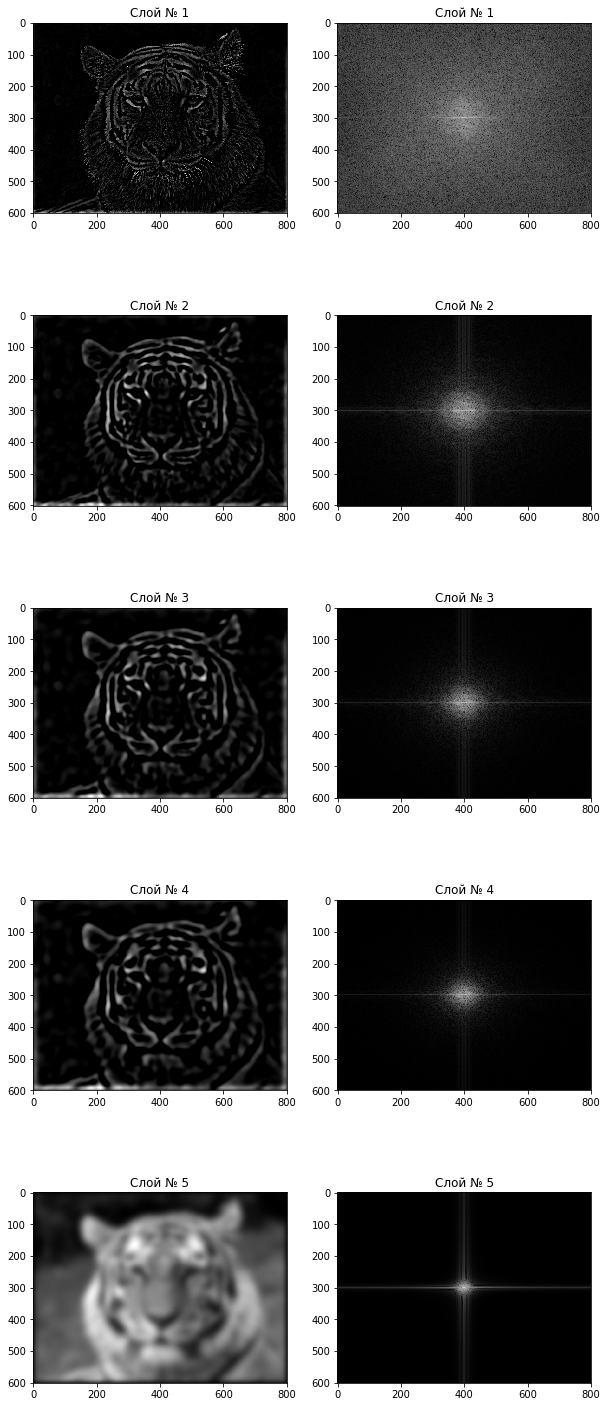

In [19]:
pyramid = laplace_pyramid(img, 5, 5)
print("sigma = 5")
plot_pyramid(pyramid, start=1)

* рассмотрим лапласовскую пирамиду при $\sigma = 8$

sigma = 8


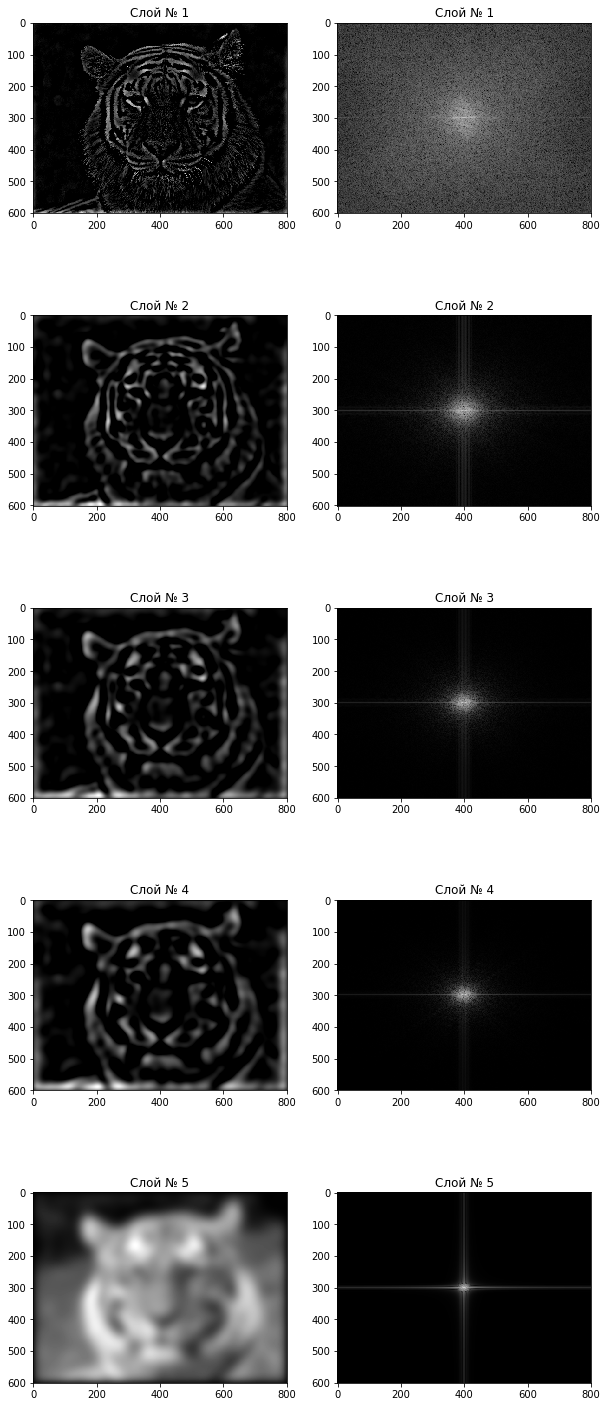

In [20]:
pyramid = laplace_pyramid(img, 8, 5)
print("sigma = 8")
plot_pyramid(pyramid, start=1)

Лапласовская пирамида выделяет поочередно высокие частоты(основные черты изображения). Последний слой лапласовской пирамиды совпадает с последним слоем гауссовской пирамиды, поэтому он содержит все оставшиеся частоты.

### 4. На основе функций построения гауссовской и лапласовской пирамиды напишите функцию склейки двух изображений на основе маски.

* загрузим склеиваемые изображения

In [21]:
picture_a = img_as_float(imread("a.png", 1))
picture_b = img_as_float(imread("b.png", 1))

* загрузим маску

In [22]:
mask = img_as_float(imread("mask.png", 1))
mask[mask > 0.5] = 1
mask[mask <= 0.5] = 0

* визуализация исходных изображений

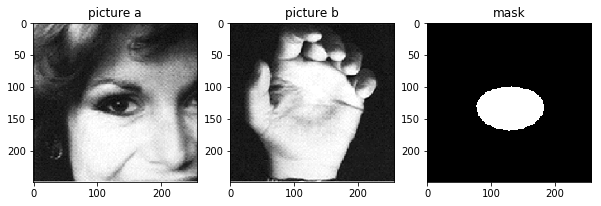

In [23]:
nrows, ncols = 1, 3

fig = plt.figure(figsize=(10,26))
axes = fig.subplots(nrows=nrows, ncols=ncols)

plt.subplot(nrows, ncols, 1).set_title("picture a")
plt.imshow(picture_a, cmap='gray')

plt.subplot(nrows, ncols, 2).set_title("picture b")
plt.imshow(picture_b, cmap='gray')

plt.subplot(nrows, ncols, 3).set_title("mask")
plt.imshow(mask, cmap='gray')
plt.show()

* функция склеивания изображений, которая возвращает слои и полученное изображение

In [24]:
def gluing_images(img_a, img_b, mask, sigma=3, n_layers=5):
    la = laplace_pyramid(img_a, sigma, n_layers)
    lb = laplace_pyramid(img_b, sigma, n_layers)
    gm = gaussian_pyramid(mask, sigma, n_layers)
    
    out_img = np.zeros(img_a.shape)
    ls = []
    
    for i in range(len(la)):
        layer = gm[i + 1] * la[i] + (1 - gm[i + 1]) * lb[i]
        out_img += layer
        ls.append(layer)
    out_img = np.clip(out_img, 0, 1)
    return (ls, out_img)

* sigma = 0.4, n_layers = 8

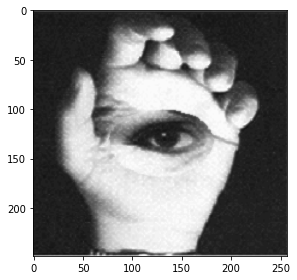

In [28]:
ls, out_img = gluing_images(picture_a, picture_b, mask, 0.4, 8)
imshow(out_img)

* sigma = 1, n_layers = 8

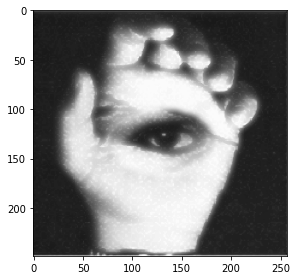

In [29]:
ls, out_img = gluing_images(picture_a, picture_b, mask, 1, 8)
imshow(out_img)

* sigma = 4, n_layers = 8

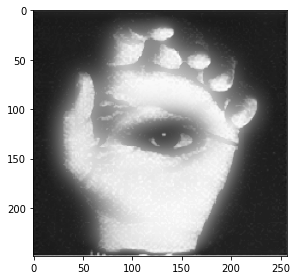

In [30]:
ls, out_img = gluing_images(picture_a, picture_b, mask, 4, 8)
imshow(out_img)

* sigma = 0.8, n_layers = 5

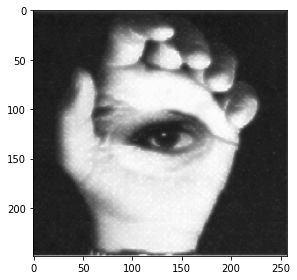

In [31]:
ls, out_img = gluing_images(picture_a, picture_b, mask, 0.8, 5)
imshow(out_img)

* sigma = 0.8, n_layers = 9

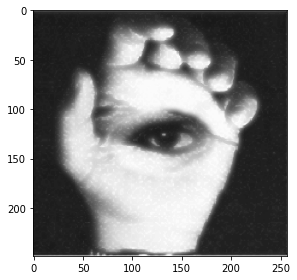

In [32]:
ls, out_img = gluing_images(picture_a, picture_b, mask, 0.8, 9)
imshow(out_img)

* sigma = 0.8, n_layers = 15

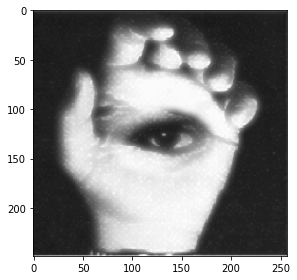

In [33]:
ls, out_img = gluing_images(picture_a, picture_b, mask, 0.8, 15)
imshow(out_img)

### 5. Подготовьте самостоятельно три набора изображений и масок для склейки и визуализируйте результаты функции.

* №1

In [52]:
picture_a = img_as_float(imread("car.jpg", 1))
picture_b = img_as_float(imread("pikachu.jpg", 1))

In [53]:
mask = img_as_float(imread("pikachu_mask.png", 1))
mask[mask > 0.5] = 1
mask[mask <= 0.5] = 0

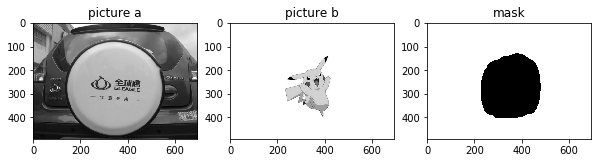

In [54]:
nrows, ncols = 1, 3

fig = plt.figure(figsize=(10,26))
axes = fig.subplots(nrows=nrows, ncols=ncols)

plt.subplot(nrows, ncols, 1).set_title("picture a")
plt.imshow(picture_a, cmap='gray')

plt.subplot(nrows, ncols, 2).set_title("picture b")
plt.imshow(picture_b, cmap='gray')

plt.subplot(nrows, ncols, 3).set_title("mask")
plt.imshow(mask, cmap='gray')
plt.show()

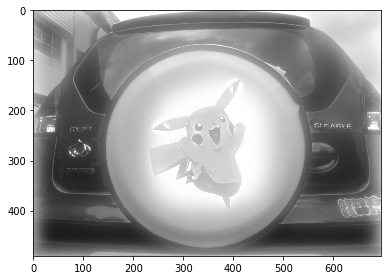

In [57]:
ls, out_img = gluing_images(picture_a, picture_b, mask, 5, 15)
imshow(out_img)

* №2

In [47]:
picture_a = img_as_float(imread("g.jpg", 1))
picture_b = img_as_float(imread("h.jpg", 1))

In [48]:
mask = img_as_float(imread("j.png", 1))
mask[mask > 0.5] = 1
mask[mask <= 0.5] = 0

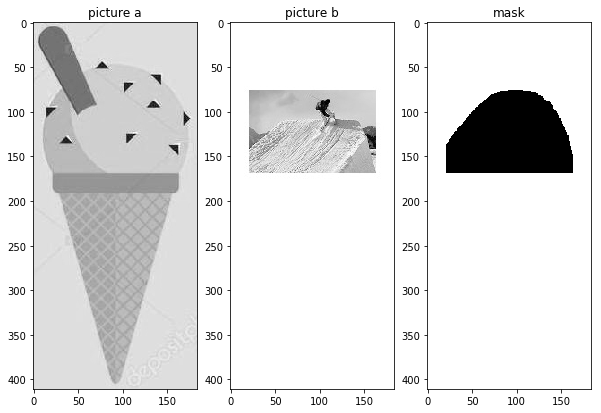

In [49]:
nrows, ncols = 1, 3

fig = plt.figure(figsize=(10,26))
axes = fig.subplots(nrows=nrows, ncols=ncols)

plt.subplot(nrows, ncols, 1).set_title("picture a")
plt.imshow(picture_a, cmap='gray')

plt.subplot(nrows, ncols, 2).set_title("picture b")
plt.imshow(picture_b, cmap='gray')

plt.subplot(nrows, ncols, 3).set_title("mask")
plt.imshow(mask, cmap='gray')
plt.show()

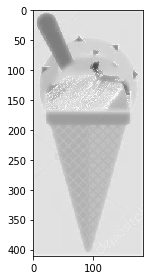

In [51]:
ls, out_img = gluing_images(picture_a, picture_b, mask, 1, 15)
imshow(out_img)

* №3

In [41]:
picture_a = img_as_float(imread("m.jpg", 1))
picture_b = img_as_float(imread("t.jpg", 1))

In [42]:
mask = img_as_float(imread("mt.jpg", 1))
mask[mask > 0.5] = 1
mask[mask <= 0.5] = 0

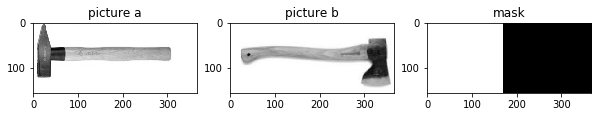

In [43]:
nrows, ncols = 1, 3

fig = plt.figure(figsize=(10,26))
axes = fig.subplots(nrows=nrows, ncols=ncols)

plt.subplot(nrows, ncols, 1).set_title("picture a")
plt.imshow(picture_a, cmap='gray')

plt.subplot(nrows, ncols, 2).set_title("picture b")
plt.imshow(picture_b, cmap='gray')

plt.subplot(nrows, ncols, 3).set_title("mask")
plt.imshow(mask, cmap='gray')
plt.show()

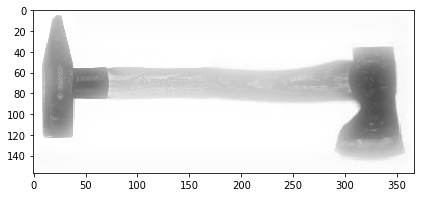

In [46]:
ls, out_img = gluing_images(picture_a, picture_b, mask, 3, 15)
imshow(out_img)